In [1]:
import pandas as pd
import utils.utils_models as utils_models

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [3]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )
df_monthly = utils_features.features_time_related(
    df_monthly, 
    frequency='ME'
    )
df_monthly = utils_features.features_lag(
    df=df_monthly, 
    col="total_revenue",
    lags=[12, 13, 14],
    group_column=['brand', 'family']
)
df_monthly = utils_features.features_rolling(
    df=df_monthly, 
    col="total_revenue",
    window_sizes=[3],
    group_column=['brand', 'family']
)
df_monthly = utils_features.create_periods_feature(
    df_monthly, 
    group_col=['brand', 'family'], 
    date_col='date', 
    target_col='total_revenue'
    )

cols_categorical = ['brand', 'family']
for col in cols_categorical:
    df_monthly[col] = df_monthly[col].astype("category")
df_monthly = df_monthly.rename(columns={"total_revenue": "y"}).set_index("date")

In [4]:
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [5]:
fc_model_lag = utils_models.NaiveLag(hyperparameters={'lag': 12})
results_cv = fc_model_lag.cross_validate(df_monthly, n_splits=2)

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average RMSE from cross-validation: 2138.3315


In [6]:
fc_model_rolling = utils_models.NaiveRollingMean(hyperparameters={'window': 3})
results_cv = fc_model_rolling.cross_validate(df_monthly, n_splits=2)

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average RMSE from cross-validation: 2210.1395


In [7]:
y_preds = fc_model_lag.predict(X=X_test)
df_preds = pd.DataFrame(
    data={
        "brand": X_test["brand"],
        "family": X_test["family"],
        "y_pred": y_preds,
        "y": y_test.values
    },
    index=X_test.index,
)

<Axes: xlabel='date'>

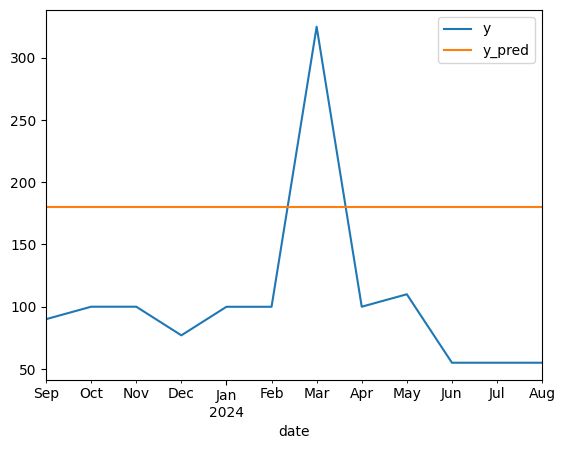

In [8]:
family = "Calcetines Running"
brand = "adidas"
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]].plot()

In [9]:
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)]

,brand,family,y_pred,y
date,,,,
2023-09-30,adidas,Calcetines Running,180.0,90.000000
2023-10-31,adidas,Calcetines Running,180.0,100.000000
2023-11-30,adidas,Calcetines Running,180.0,100.000000
2023-12-31,adidas,Calcetines Running,180.0,77.000000
2024-01-31,adidas,Calcetines Running,180.0,99.949997
2024-02-29,adidas,Calcetines Running,180.0,99.949997
2024-03-31,adidas,Calcetines Running,180.0,324.950012
2024-04-30,adidas,Calcetines Running,180.0,100.000000
2024-05-31,adidas,Calcetines Running,180.0,110.000000


In [10]:
df_monthly[(df_monthly["family"] == family) & (df_monthly["brand"] == brand)]

,brand,family,y,year,month_of_year,sin_month_of_year,cos_month_of_year,total_revenue_lag_12,total_revenue_lag_13,total_revenue_lag_14,total_revenue_rolling_mean_3w,total_revenue_rolling_std_3w,total_revenue_rolling_sum_3w,feature_periods
date,,,,,,,,,,,,,,
2020-09-30,adidas,Calcetines Running,661.599976,2020,9,-1.000,-0.000,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-10-31,adidas,Calcetines Running,565.950012,2020,10,-0.866,0.500,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2020-11-30,adidas,Calcetines Running,958.950012,2020,11,-0.500,0.866,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2020-12-31,adidas,Calcetines Running,1120.649902,2020,12,-0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2021-01-31,adidas,Calcetines Running,1641.449951,2021,1,0.500,0.866,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2021-02-28,adidas,Calcetines Running,3063.000000,2021,2,0.866,0.500,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2021-03-31,adidas,Calcetines Running,3270.650146,2021,3,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2021-04-30,adidas,Calcetines Running,3621.050049,2021,4,0.866,-0.500,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2021-05-31,adidas,Calcetines Running,3949.000000,2021,5,0.500,-0.866,NaN,NaN,NaN,NaN,NaN,NaN,9.0


In [11]:
df_monthly

,brand,family,y,year,month_of_year,sin_month_of_year,cos_month_of_year,total_revenue_lag_12,total_revenue_lag_13,total_revenue_lag_14,total_revenue_rolling_mean_3w,total_revenue_rolling_std_3w,total_revenue_rolling_sum_3w,feature_periods
date,,,,,,,,,,,,,,
2021-09-30,Columbia,Bañadores Natación,99.949997,2021,9,-1.000,-0.000,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2021-10-31,Columbia,Bañadores Natación,99.949997,2021,10,-0.866,0.500,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2021-11-30,Columbia,Bañadores Natación,99.949997,2021,11,-0.500,0.866,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2021-12-31,Columbia,Bañadores Natación,99.949997,2021,12,-0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2022-01-31,Columbia,Bañadores Natación,99.949997,2022,1,0.500,0.866,NaN,NaN,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,adidas,Zuecos Urban,99.949997,2024,3,1.000,0.000,99.949997,99.949997,99.949997,153.283335,92.376052,459.850006,32.0
2024-04-30,adidas,Zuecos Urban,99.949997,2024,4,0.866,-0.500,299.849976,99.949997,99.949997,99.949997,0.000000,299.849991,33.0
2024-05-31,adidas,Zuecos Urban,199.899994,2024,5,0.500,-0.866,299.849976,299.849976,99.949997,166.583323,115.412306,499.749969,34.0
